<a href="https://colab.research.google.com/github/cdavidrios/TDS1_Banco_de_Filtros/blob/main/Bancos_de_filtros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Banco de filtros

Autores

* Daniel Escobar Grisales
* Cristian David Rios Urrego
* Juan Rafael Orozco Arroyave

En los capítulos anteriores aprendimos a representar y analizar señales en el dominio de la frecuencia, lo que nos permitió observar cómo la energía de una señal se distribuye a lo largo de diferentes componentes espectrales. Sin embargo, los espectros suelen contener mucha información redundante, y no siempre es necesario conservar cada detalle frecuencial para caracterizar una señal.

Los bancos de filtros son una herramienta que permite comprimir y organizar la información espectral dividiendo el espectro en un conjunto de bandas adyacentes. Cada banda actúa como un filtro que agrupa la energía en un rango de frecuencias determinado, lo que da lugar a una representación más compacta y estructurada de la señal.

### Carga, pre-procesamiento y visualización de la señal

In [1]:
from scipy.io.wavfile import read # libreria para lectura de archivos de audio
from IPython.display import Audio # para escuchar la senal
import matplotlib.pyplot as plt # libreria usada para graficas
import numpy as np
from scipy.stats import pearsonr


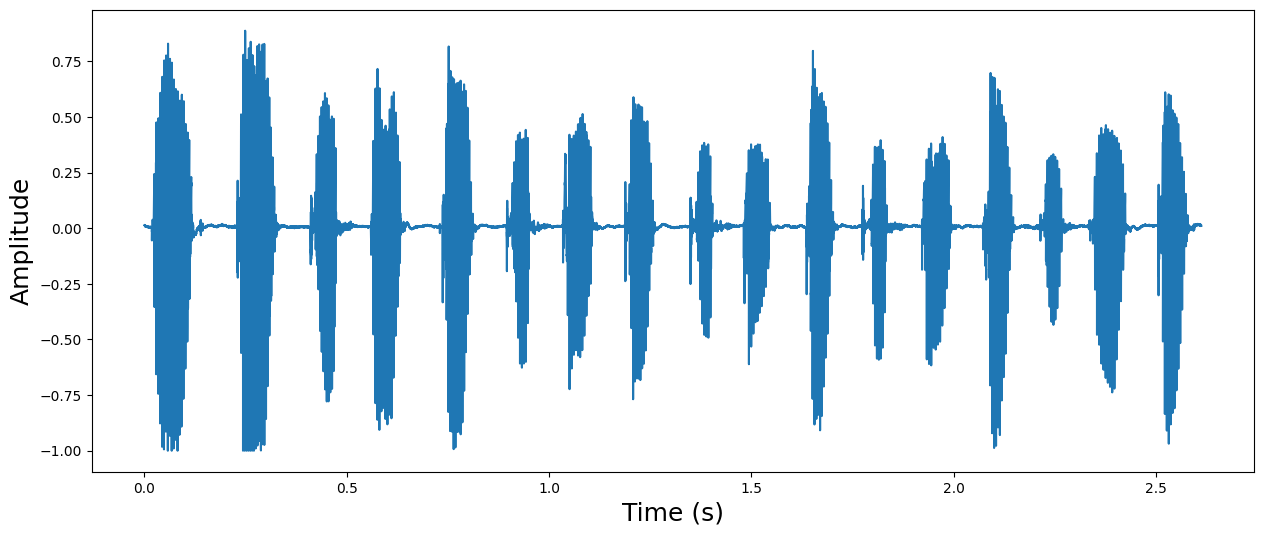

In [2]:

file_audio=('senal.wav') # Ruta del archivo con la senal
fs, x=read(file_audio) # Cargar el archivo
x=x/float(max(abs(x))) # escala la amplitud de la senal
t=np.arange(0, float(len(x))/fs, 1.0/fs) # Vector de tiempo

plt.figure(figsize=(15,6))
plt.plot(t,x) # Dibujar la grafica
# Los siguientes dos comandos dibujan las etiquetas de los ejes
plt.xlabel('Time (s)',fontsize=18) # Etiqueta eje X
plt.ylabel('Amplitude',fontsize=18) # Etiqueta eje Y
plt.show() # Mostrar la grafica
Audio(x, rate=fs) # para escuchar la senal, si se desea

### Extracción de segmentos y aplicación de ventana

En este caso utilizaremos un enventanado de 50 ms con un avance (hop) de 10 ms. Este proceso nos permitirá construir un espectrograma, donde en cada segmento de 50 ms calcularemos la DFT. Luego, avanzaremos 10 ms y tomaremos un nuevo segmento de la señal para repetir el proceso. De esta manera, obtendremos aproximadamente 256 ventanas. Este espectrograma nos permitirá representar la evolución espectral de la señal a lo largo del tiempo.

In [3]:
def extraer_ventanas(signal, size, step):

    n_seg = int((len(signal) - size) / step)

    # extraer segmentos
    windows=[]
    for i in range(n_seg):

        windows.append(signal[i*step:i*step+size])

    # stack (cada fila es una ventana)
    return np.vstack(windows)

size = int(0.050*fs)
step = int(0.010*fs)
ventanas = extraer_ventanas(x, size, step)
len(ventanas)

win_hamming=np.hamming(size)

ventanas_proc = ventanas*np.hamming(size)

In [4]:
int((len(x) - size) / step)

256

### Transformada de Fourier

Cuando calculamos la DFT (Transformada Discreta de Fourier) utilizando una ventana de longitud $N=1024$ muestras, el resultado contiene $N$ valores complejos que representan las componentes de frecuencia desde $\frac{-f_s}{2}$ hasta $\frac{f_s}{2}$. En este caso elegimos una ventana de 1024 muestras porque es la potencia de 2 más cercana a la duración de 50 ms, considerando que la frecuencia de muestreo es $f_s = 16k$Hz.

Dado que la señal es real, su espectro es simétrico, por lo que solo se conserva la mitad positiva (de 0 a $\frac{f_s}{2}$). Esto deja un total de $\frac{N}{2} + 1 = 513$ frecuencias únicas. En consecuencia, el espectrograma puede representarse como una matriz $\mathbb{R}^{513 \times 256}$, donde cada columna corresponde a una de las 256 ventanas temporales, y cada fila representa la energía en una de las 513 frecuencias del rango de 0 a 8 kHz.

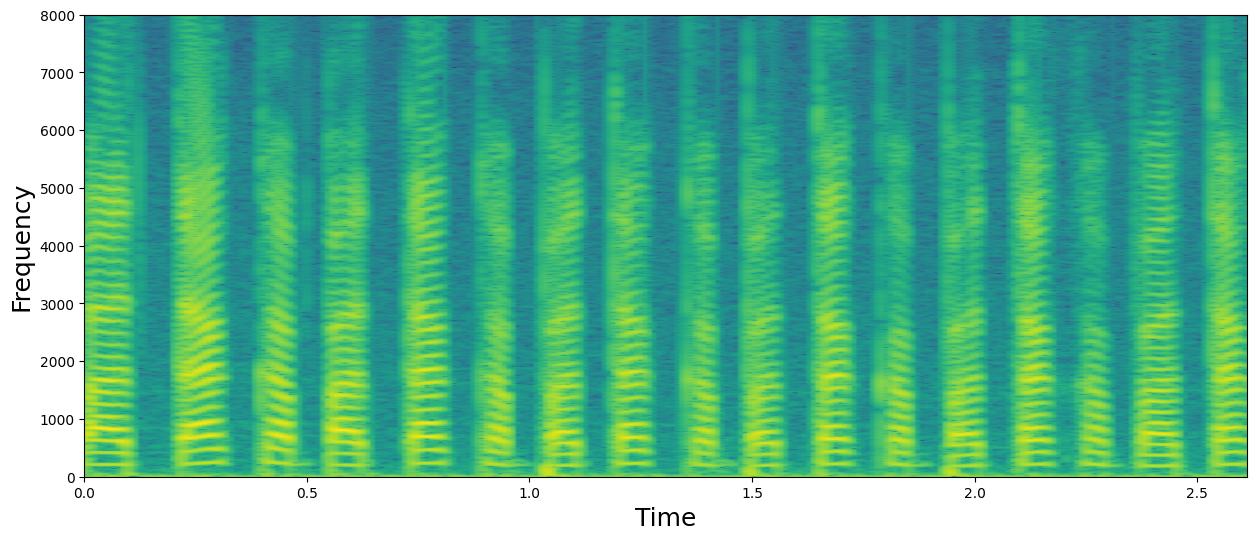

In [5]:
def potspec(X, size, n_padded_min=0):

    # Zero padding para la proxima potencia de 2
    if n_padded_min==0:
        n_padded = max(n_padded_min, int(2 ** np.ceil(np.log(size) / np.log(2))))
    else:
        n_padded = n_padded_min

    # Transformada de Fourier
    Y = np.fft.fft(X, n=n_padded)
    Y = np.absolute(Y)

    # non-redundant part
    m = int(n_padded / 2) + 1
    Y = Y[:,:m]

    return np.abs(Y)**2, n_padded

espectro,nfft=potspec(ventanas_proc,size,1024)
espectro=np.flipud(10*np.log10(espectro).T)
plt.figure(figsize=(15,6))
plt.imshow(espectro,aspect='auto', extent=[0, len(x)/fs, 0, fs//2])
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.show()

In [6]:
# Tamaño del espectrograma
print("Tamaño del espectrograma: ", espectro.shape)

Tamaño del espectrograma:  (513, 256)


### Agrupación en bandas

Las frecuencias pueden agruparse en una cantidad $k$ de bandas con el objetivo de comprimir la información contenida en el espectrograma. Este proceso consiste en dividir el rango de frecuencias en
k bandas y calcular, para cada una de ellas, la energía promedio dentro de ese intervalo. De esta manera, el espectro se proyecta a un espacio de menor dimensión, representado como $\mathbb{R}^{k \times 256}$ donde $k$ corresponde al número de bandas y 256 al número de ventanas temporales. Por ejemplo, si se considera un valor de
$k=20$, el espectrograma comprimido tendrá solo 20 componentes frecuenciales por cada ventana de tiempo.

In [7]:
# Determina el número de bandas
N = 20

# Crear un array para almacenar el espectrograma comprimido
compressed_spectrogram = np.zeros((N, espectro.shape[1]))

# Calcular el tamaño de cada banda
bins_per_band = espectro.shape[0] // N

for i in range(N):
    # Determinar los índices de los bins que corresponden a la banda actual
    start_bin = i * bins_per_band
    end_bin = (i + 1) * bins_per_band if i != N - 1 else espectro.shape[0]

    # Agrupar los bins dentro de la banda actual
    compressed_spectrogram[i, :] = np.mean(espectro[start_bin:end_bin, :], axis=0)

# Tamaño del espectro comprimido
print("Tamaño del espectro: ", compressed_spectrogram.shape)

Tamaño del espectro:  (20, 256)


In [8]:
bins_per_band

25

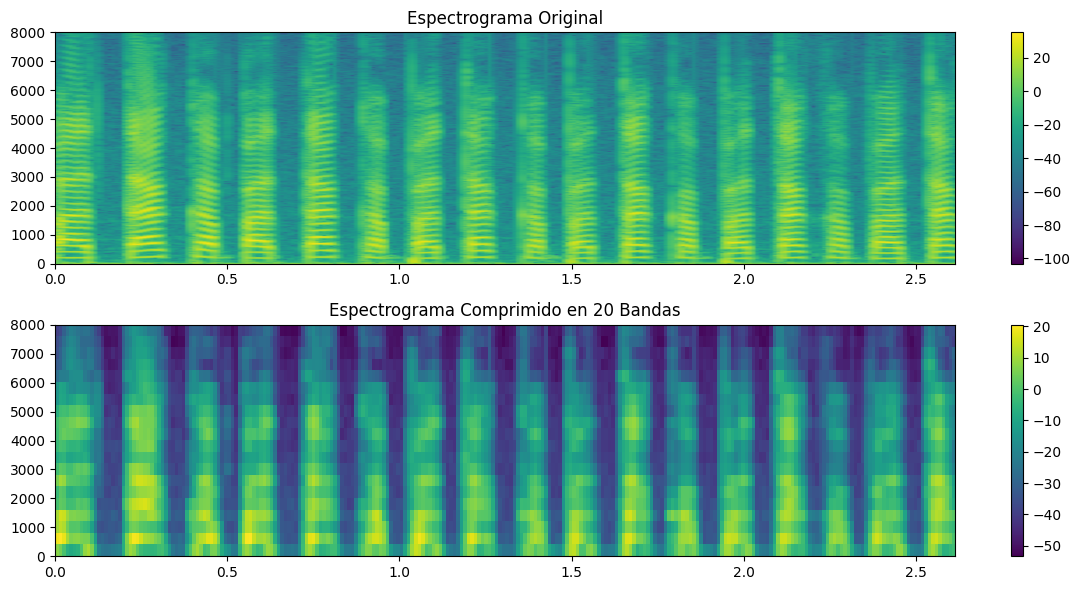

In [9]:
# Visualizar el espectrograma original y el comprimido
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title('Espectrograma Original')
plt.imshow(espectro,aspect='auto', extent=[0, len(x)/fs, 0, fs//2])
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title('Espectrograma Comprimido en {} Bandas'.format(N))
plt.imshow(compressed_spectrogram,aspect='auto', extent=[0, len(x)/fs, 0, fs//2])
plt.colorbar()

plt.tight_layout()
plt.show()